In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
from sklearn import preprocessing
from scipy import signal
import plotly.graph_objects as go

import os


In [ ]:
#print(os.getcwd())
u_df = pd.read_csv('../unlabelled_skin_assay.csv')
u_df.head()

In [ ]:
pfux7_in_df = pd.read_csv('../TrainingLib/pfux7/input_data_pfux7.csv')
pfux7_out_df = pd.read_csv('../TrainingLib/pfux7/output_data_pfux7.csv')
gel_in_df = pd.read_csv('../TrainingLib/geltesting/input_data_gel_v3.csv')
gel_out_df = pd.read_csv('../TrainingLib/geltesting/output_data_gel_v3.csv')

In [ ]:
gel_in_df.head()

In [ ]:
gel_df = gel_in_df.merge(gel_out_df,left_on='Row',right_on='Wells')

In [ ]:
pfux7_df = pfux7_in_df.merge(pfux7_out_df,left_on='Row',right_on='Wells')



In [ ]:
df = pd.concat([gel_df,pfux7_df])
df.to_csv('../TrainingLib/semi_supervised/labelled_data.csv')
del(gel_in_df)
del(gel_out_df)
del(pfux7_in_df)
del(pfux7_out_df)

## Peak Extraction
In this section we will take the raw electropherograms and extract individual peaks. For that we need to preprocess 
the data. 

### Preprocessing
We will transform the signal so that it is normalized and noise-free. 


In [14]:
df= pd.read_csv('../TrainingLib/semi_supervised/labelled_data.csv',index_col=0)
u_df = pd.read_csv('../unlabelled_skin_assay.csv')

In [15]:
df = df.drop('Wells',axis=1).set_index('Row')

In [123]:
X_l = df.filter(regex='t_',axis=1).copy()
X_u = u_df.filter(regex='t_',axis=1).copy()

In [124]:
# Gaussian Filter
X_l_f = X_l\
    .rolling(window=10,win_type='general_gaussian',center=True,axis=1)\
    .mean(power=2,width=0.8)
X_u_f = X_u\
    .rolling(window=10,win_type='general_gaussian',center=True,axis=1)\
    .mean(power=2,width=0.8)
# Remove baseline
X_l_f = X_l_f\
    .add(-X_l_f.rolling(window=50,min_periods=1,axis=1).min())
X_u_f = X_u_f\
    .add(-X_u_f.rolling(window=50,min_periods=1,axis=1).min())
# Min Max Scale
x_l_f = X_l_f.values #returns a numpy array
x_u_f = X_u_f.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled_l = np.transpose(min_max_scaler.fit_transform(x_l_f.T))
x_scaled_u = np.transpose(min_max_scaler.fit_transform(x_u_f.T))
X_l_f = pd.DataFrame(x_scaled_l,columns=X_l.columns)
X_u_f = pd.DataFrame(x_scaled_u,columns=X_u.columns)



In [125]:
#x_f = X_l_f.sample(n=1,random_state=10).values
#x = X_l.sample(n=1,random_state=10).values
x_f = X_l_f.iloc[0,:].values
x = X_l.iloc[0,:].values
#x = X_l.sample(n=1).values

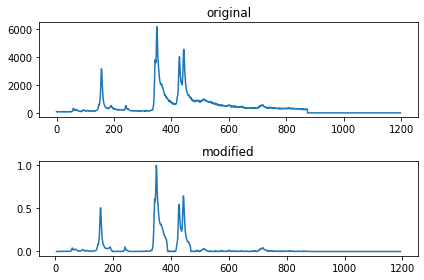

In [126]:
fig,ax = plt.subplots(nrows=2)
ax[0].plot(x.flatten())
ax[0].set_title('original')
ax[1].plot(x_f.flatten())
ax[1].set_title('modified')
plt.tight_layout()

In [127]:
del(X_l)
del(X_u)
del(x_u_f)
del(x_l_f)
del(x_scaled_l)
del(x_scaled_u)
del(min_max_scaler)

### Peak Extraction
We will now extract peaks and their position


In [128]:
X_l_f.set_index(df.index,inplace=True)
X_u_f.set_index(u_df.index,inplace=True)

In [129]:
def get_peaks(df,window,start=1500):
    pk_data = []
    for idx,row in df.iterrows():
        peaks = signal.find_peaks(row.values,prominence=0.1)
        #check if blank
        if len(peaks[0]) >= 20:
            continue
        for loc,prom in zip(peaks[0],peaks[1].get('prominences')):
            pk = row.values[loc-window:loc+window]
            t = start + loc
            pk = [idx,t] + pk.flatten().tolist()
            pk_data.append(pk)
    out = pd.DataFrame(pk_data)
    out.rename({0:'file_id',1:'x'},axis=1,inplace=True)
    
    return out
peak_df = get_peaks(X_l_f,10)

In [130]:
peak_u_df = get_peaks(X_u_f,10)
Y = df.filter(regex='values')
#peak_df.head()

In [131]:
def match_labels(df):
    y = Y.loc[df.file_id].values
    if (np.abs((y-df.x))<2.0).any():
        label = 1
    else:
        label = 0
    return label

#labels = peak_df.apply(match_labels,axis=1)

In [132]:
labels = peak_df.apply(match_labels,axis=1)

In [133]:
peak_df.head(20)


,file_id,x,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,20190814_EFSYMB_6_geltest_LPA_3_1diluted_pfux7...,1657,0.072214,0.084023,0.080332,0.085349,0.109464,0.142351,0.188487,0.258657,...,0.506459,0.475301,0.389373,0.309256,0.251592,0.186901,0.144204,0.124257,0.103209,0.085576
1,20190814_EFSYMB_6_geltest_LPA_3_1diluted_pfux7...,1850,0.177055,0.294539,0.441576,0.564403,0.613771,0.594455,0.576869,0.628023,...,1.000000,0.934976,0.803789,0.676313,0.607148,0.559899,0.510077,0.473239,0.427409,0.386399
2,20190814_EFSYMB_6_geltest_LPA_3_1diluted_pfux7...,1928,0.017496,0.038551,0.067809,0.087296,0.101900,0.128406,0.183925,0.269334,...,0.547178,0.526926,0.459349,0.385905,0.329654,0.296976,0.265732,0.258762,0.248773,0.235170
3,20190814_EFSYMB_6_geltest_LPA_3_1diluted_pfux7...,1943,0.296976,0.265732,0.258762,0.248773,0.235170,0.239287,0.278478,0.347079,...,0.645148,0.641077,0.569082,0.467756,0.397629,0.339014,0.283918,0.234427,0.205282,0.190497
4,20190814_EFSYMB_6_geltest_LPA_3_1diluted_pfux7...,1642,0.062819,0.085935,0.097649,0.096528,0.105490,0.136676,0.185408,0.233831,...,0.562444,0.545554,0.459734,0.373628,0.294097,0.220443,0.160111,0.117794,0.098581,0.090342
5,20190814_EFSYMB_6_geltest_LPA_3_1diluted_pfux7...,1854,0.033085,0.037353,0.047019,0.061832,0.090728,0.152683,0.248348,0.388573,...,0.649488,0.566369,0.481582,0.467623,0.504268,0.604883,0.766765,0.943531,1.000000,0.904312
6,20190814_EFSYMB_6_geltest_LPA_3_1diluted_pfux7...,1862,0.534770,0.633554,0.649488,0.566369,0.481582,0.467623,0.504268,0.604883,...,1.000000,0.904312,0.764997,0.637904,0.538464,0.470195,0.425606,0.375990,0.336869,0.301442
7,20190814_EFSYMB_6_geltest_LPA_3_1diluted_pfux7...,1946,0.027092,0.040734,0.068094,0.096350,0.120600,0.178432,0.260444,0.363169,...,0.649923,0.579325,0.477944,0.398253,0.333827,0.292508,0.266868,0.252814,0.253292,0.285651
8,20190814_EFSYMB_6_geltest_LPA_3_1diluted_pfux7...,1960,0.333827,0.292508,0.266868,0.252814,0.253292,0.285651,0.345851,0.435480,...,0.718756,0.684016,0.604733,0.525572,0.415296,0.343969,0.311930,0.270093,0.241243,0.226568
9,20190814_EFSYMB_6_geltest_LPA_3_1diluted_pfux7...,1705,0.073289,0.077529,0.082673,0.093223,0.117448,0.156928,0.206033,0.266072,...,0.453323,0.405809,0.344102,0.282872,0.214732,0.161951,0.127834,0.102682,0.082672,0.067523


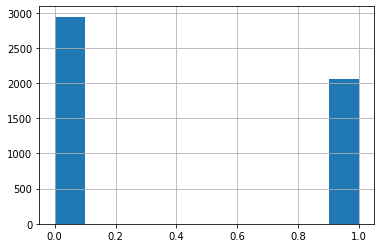

In [134]:
labels.hist()



In [66]:
idx = 735
indices = signal.find_peaks(X_l_f.iloc[idx,:].values,prominence=0.1)[0]
fig = go.Figure()
fig.add_trace(go.Scatter(
    y=X_l_f.iloc[idx,:].values,
    mode='lines+markers',
    name='Original Plot'
))

fig.add_trace(go.Scatter(
    x=indices,
    y=[X_l_f.iloc[idx,:].values[j] for j in indices],
    mode='markers',
    marker=dict(
        size=8,
        color='red',
        symbol='cross'
    ),
    name='Detected Peaks'
))

fig.show()


In [135]:
labels = labels.to_frame()
labels.columns=['label']

In [136]:
peak_df.to_csv('peak_signals.csv')
labels.to_csv('peak_labels.csv')
peak_u_df.to_csv('peak_signals_unlabelled.csv')

## Training Peak Data
We will now try to predict whether a peak is a real peak from the data.
We have some unlabelled input, which we will try to use to our advantage using semi-supervised learning.



In [116]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score



In [137]:
peak_df = pd.read_csv('peak_signals.csv',index_col=0)
labels = pd.read_csv('peak_labels.csv',index_col=0)
peak_u_df = pd.read_csv('peak_signals_unlabelled.csv',index_col=0)

In [141]:
peak_df.drop('file_id',axis=1,inplace=True)
peak_df.head()

,x,2,3,4,5,6,7,8,9,10,...,12,13,14,15,16,17,18,19,20,21
0,1657,0.072214,0.084023,0.080332,0.085349,0.109464,0.142351,0.188487,0.258657,0.354917,...,0.506459,0.475301,0.389373,0.309256,0.251592,0.186901,0.144204,0.124257,0.103209,0.085576
1,1850,0.177055,0.294539,0.441576,0.564403,0.613771,0.594455,0.576869,0.628023,0.768377,...,1.000000,0.934976,0.803789,0.676313,0.607148,0.559899,0.510077,0.473239,0.427409,0.386399
2,1928,0.017496,0.038551,0.067809,0.087296,0.101900,0.128406,0.183925,0.269334,0.389496,...,0.547178,0.526926,0.459349,0.385905,0.329654,0.296976,0.265732,0.258762,0.248773,0.235170
3,1943,0.296976,0.265732,0.258762,0.248773,0.235170,0.239287,0.278478,0.347079,0.452334,...,0.645148,0.641077,0.569082,0.467756,0.397629,0.339014,0.283918,0.234427,0.205282,0.190497
4,1642,0.062819,0.085935,0.097649,0.096528,0.105490,0.136676,0.185408,0.233831,0.322183,...,0.562444,0.545554,0.459734,0.373628,0.294097,0.220443,0.160111,0.117794,0.098581,0.090342


In [139]:
labels.head()

,label
0,0
1,1
2,1
3,1
4,0


In [ ]:
model = KNeighborsClassifier()
model.fit(x)

In [142]:
classifier_factory = [KNeighborsClassifier(),RandomForestClassifier()]
num_folds = 3
for model in classifier_factory:
    
    scores = cross_val_score(model,peak_df,labels,cv=num_folds,scoring='f1')
    score_description = "%0.2f (+- %0.2f)" % (scores.mean(),scores.std())
    print('{model:25} CV-5 F1 SCORE: {score}'.format(
        model= model.__class__.__name__,
        score=score_description
    ) )

KNeighborsClassifier      CV-5 F1 SCORE: nan (+- nan)
RandomForestClassifier    CV-5 F1 SCORE: nan (+- nan)


/anaconda3/envs/ScoringElectropherograms/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Input contains NaN, infinity or a value too large for dtype('float64').


/anaconda3/envs/ScoringElectropherograms/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Input contains NaN, infinity or a value too large for dtype('float64').


/anaconda3/envs/ScoringElectropherograms/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Input contains NaN, infinity or a value too large for dtype('float64').


/anaconda3